In [32]:
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks


from matplotlib.pyplot import imshow
from PIL import Image

In [217]:
# Basic configuration
image_w = 512
image_h = 384
np.random.seed(123)

In [218]:
import sys
!{sys.executable} -m pip install pillow

In [230]:
OUTPUT_DIR = 'image_ocr'

# character classes and matching regex filter
regex = r'^[a-z ]+$'
alphabet = u'abcdefghijklmnopqrstuvwxyz '



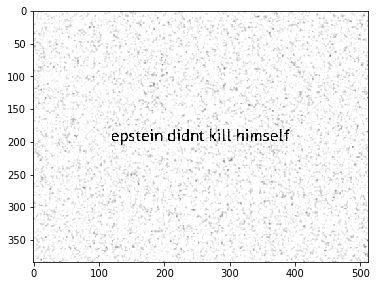

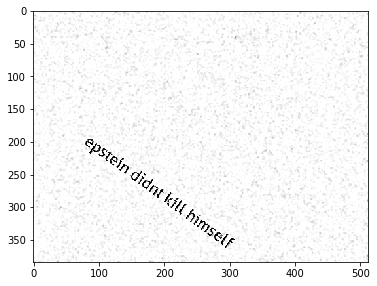

In [231]:
from PIL import Image, ImageDraw, ImageFont

def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck

def draw_text(text, w, h, translation=True, rotation=True, multi_font=True):
    base_image = Image.new('RGB', (w,h), (255,255,255))

    #TODO download more fonts from fonts.google.com to support multiple fonts
    fnt = ImageFont.truetype('fonts/Aller_Rg.ttf', 24)
    text_dim = fnt.getsize(text)
    text_image = Image.new('RGBA', text_dim, (0,0,0,0))
    
    # Draw text
    d = ImageDraw.Draw(text_image)
    d.text((0,0), text, font=fnt, fill=(0,0,0))
    
    if(rotation):
        rotation_degrees = np.random.randint(0, 359)
        text_image = text_image.rotate(rotation_degrees, expand=1)
    
    if text_image.size[0] > base_image.size[0] or text_image.size[1] > base_image.size[1]:
        raise IOError('Text will not fit in image size. Increase image size or decrease max text length.')
    
    max_translate = tuple(t//2 for t in np.subtract(base_image.size, text_image.size))
    
    location = ((w - text_image.size[0])//2 ,(h - text_image.size[1])//2)
    if(translation):
        translate_x = np.random.randint(-max_translate[0],max_translate[0])
        translate_y = np.random.randint(-max_translate[1],max_translate[1])                                    
        location = (location[0] + translate_x, location[1] + translate_y)
    
    base_image.paste(text_image, location, text_image)
    
    a = np.array(base_image)
    a = a[:, :, 0]
    # Convert the 0-255 int value to float from 0-1 
    a = a.astype(np.float32) / 255
    # a = np.expand_dims(a, 0)
    a = speckle(a)
    
    return a


def show_single_channel_image(a):
    a = a.reshape((image_h, image_w))
    plt.rcParams["figure.figsize"] = (6,6)
    plt.imshow(a, cmap='Greys_r')
    plt.show()

test_image = draw_text('epstein didnt kill himself',image_w, image_h, translation=False, rotation=False)
show_single_channel_image(test_image)

test_image = draw_text('epstein didnt kill himself',image_w, image_h, translation=True, rotation=True)
show_single_channel_image(test_image)





In [ ]:
# TODO rewrite this cell
def shuffle_mats_or_lists(matrix_list, stop_ind=None):
    ret = []
    assert all([len(i) == len(matrix_list[0]) for i in matrix_list])
    len_val = len(matrix_list[0])
    if stop_ind is None:
        stop_ind = len_val
    assert stop_ind <= len_val

    a = list(range(stop_ind))
    np.random.shuffle(a)
    a += list(range(stop_ind, len_val))
    for mat in matrix_list:
        if isinstance(mat, np.ndarray):
            ret.append(mat[a])
        elif isinstance(mat, list):
            ret.append([mat[i] for i in a])
        else:
            raise TypeError('`shuffle_mats_or_lists` only supports '
                            'numpy.array and list objects.')
    return ret


# Translation of characters to unique integer values
def text_to_labels(text):
    ret = []
    for char in text:
        ret.append(alphabet.find(char))
    return ret


# Reverse translation of numerical classes back to characters
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)


# only a-z and space..probably not to difficult
# to expand to uppercase and symbols

def is_valid_str(in_str):
    search = re.compile(regex, re.UNICODE).search
    return bool(search(in_str))


0
10
